In [8]:
import os
import scipy
import logging
import tempfile
import numpy as np
import nibabel as nib
import multiprocessing
from dipy.data import get_sphere
from dipy.io import read_bvals_bvecs
from joblib import Parallel, delayed
from dipy.core.sphere import Sphere
from dipy.reconst.shm import sf_to_sh
from dipy.core.gradients import gradient_table_from_bvals_bvecs
from scilpy.reconst.multi_processes import fit_from_model, convert_sh_basis
from scilpy.reconst.raw_signal import compute_sh_coefficients
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.shm import real_sh_descoteaux_from_index, sh_to_sf
from scilpy.utils.bvec_bval_tools import (DEFAULT_B0_THRESHOLD,
                                          check_b0_threshold, identify_shells,
                                          is_normalized_bvecs, normalize_bvecs)

/home/local/VANDERBILT/kanakap/py38-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def compute_dwi_attenuation(dwi_weights: np.ndarray, b0: np.ndarray):
    """ Compute signal attenuation by dividing the dwi signal with the b0.
    Parameters:
    -----------
    dwi_weights : np.ndarray of shape (X, Y, Z, #gradients)
        Diffusion weighted images.
    b0 : np.ndarray of shape (X, Y, Z)
        B0 image.
    Returns
    -------
    dwi_attenuation : np.ndarray
        Signal attenuation (Diffusion weights normalized by the B0).
    """
    b0 = b0[..., None]  # Easier to work if it is a 4D array.

    # Make sure that, in every voxels, weights are lower in the b0. Should
    # always be the case, but with the noise we never know!
    erroneous_voxels = np.any(dwi_weights > b0, axis=3)
    nb_erroneous_voxels = np.sum(erroneous_voxels)
    if nb_erroneous_voxels != 0:
        logging.info("# of voxels where `dwi_signal > b0` in any direction: "
                     "{}".format(nb_erroneous_voxels))
        dwi_weights = np.minimum(dwi_weights, b0)

    # Compute attenuation
    dwi_attenuation = dwi_weights / b0

    # Make sure we didn't divide by 0.
    dwi_attenuation[np.logical_not(np.isfinite(dwi_attenuation))] = 0.

    return dwi_attenuation

In [23]:
# DWI TO SF (With the voxelwise bvec and bval)
def reconstruct_signal_at_voxel(i,j,k,n,og_bvec,og_bval,bvec_stack,bval_stack,dwi_hat):
        dwi = n[i][j][k]
        og_gradient_table = gradient_table_from_bvals_bvecs(og_bval, og_bvec)
        vec = bvec_stack[i,j,k,:,:]
        val = bval_stack[i,j,k,:]
        gradient_table = gradient_table_from_bvals_bvecs(val, vec)
        sh_order=10
        basis_type='tournier07'
        smooth=0.00
        use_attenuation=True
        force_b0_threshold=False
        mask=None
        sphere=None

        # Extracting infos
        b0_mask = gradient_table.b0s_mask
        bvecs = gradient_table.bvecs
        bvals = gradient_table.bvals
        
        dwi = np.reshape(dwi,[1,1,1,bvals.shape[0]])

        if not is_normalized_bvecs(bvecs):
                logging.warning("Your b-vectors do not seem normalized...")
                bvecs = normalize_bvecs(bvecs)

        b0_threshold = check_b0_threshold(force_b0_threshold, bvals.min())

        # Ensure that this is on a single shell.
        shell_values, _ = identify_shells(bvals)
        shell_values.sort()
        # if shell_values.shape[0] != 2 or shell_values[0] > b0_threshold:
        #     raise ValueError("Can only work on single shell signals.")

        # Keeping b0-based infos
        bvecs = bvecs[np.logical_not(b0_mask)]
        weights = dwi[..., np.logical_not(b0_mask)]

        # scale singal with bval correction 
        b0 = dwi[..., b0_mask].mean(axis=3)
        norm_gg = np.divide(bvals[np.logical_not(b0_mask)] , og_bval[np.logical_not(b0_mask)])
        weights_scaled = b0 * np.exp (np.divide( (np.log (np.divide(weights,b0)) ) , norm_gg))

        # Compute attenuation using the b0.
        if use_attenuation:
                weights_scaled = compute_dwi_attenuation(weights_scaled, b0)

        # # Get cartesian coords from bvecs # from here cut debugging
        sphere = Sphere(xyz=bvecs)

        # SF TO SH
        # Fit SH
        sh = sf_to_sh(weights_scaled, sphere, sh_order, basis_type, smooth=smooth)

        # Apply mask
        if mask is not None:
                sh *= mask[..., None]

        # Reconstructing DWI
        # SH to SF 
        og_bvecs = og_gradient_table.bvecs

        if not is_normalized_bvecs(og_bvecs):
                logging.warning("Your b-vectors do not seem normalized...")
                og_bvecs = normalize_bvecs(og_bvecs)

        og_bvecs = og_bvecs[np.logical_not(b0_mask)]

        og_sphere = Sphere(xyz=og_bvecs)

        sf = sh_to_sf(sh, og_sphere, sh_order=sh_order, basis_type=basis_type)

        # SF TO DWI (inverse of compute_dwi_attenuation) here weights_hat is DWI with bvec corrected
        b0 = b0[..., None]
        weights_hat = sf * b0 
        dwi_hat[i,j,k,:] = weights_hat


In [11]:
n = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
vol = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz')
og_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bvec'
ob_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
vec_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bvec'
val_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bval'

In [12]:
og_bval, og_bvec = read_bvals_bvecs(ob_file,og_file)
ind_1000 = np.where(og_bval == 1000)
ind_2000 = np.where(og_bval == 2000)
ind_b0 = np.nonzero(og_bval==0)
ind_b0 = np.squeeze(ind_b0)
ind_0_1000 = np.where((og_bval == 0) | (og_bval == 1000))
ind_0_2000 = np.where((og_bval == 0) | (og_bval == 2000))

# LOAD THE VOXELWISE BVALS AND BVECS
bvec_vols = []
for i in sorted(os.listdir(vec_folder)):
    if i.endswith('.nii.gz'):
        bvec_vol = nib.load(vec_folder + '/' + i).get_fdata()
        bvec_vol = np.expand_dims(bvec_vol,4)
        bvec_vol = np.transpose(bvec_vol,(0,1,2,4,3))
        bvec_vols.append(bvec_vol)
bvec_stack = np.stack(bvec_vols,3)
bvec_stack = bvec_stack.squeeze()

bval_vols = []
for i in sorted(os.listdir(val_folder)):
    if i.endswith('.nii.gz'):
        bval_vol = nib.load(val_folder + '/' + i).get_fdata()
        bval_vols.append(bval_vol)
bval_stack = np.stack(bval_vols,3)


In [27]:
num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

# for dwi with 0 1000
len1 = ind_0_1000[0]
dwi_hat_path1 = os.path.join(path,'dwi_hat1.mmap')
dwi_hat1 = np.memmap(dwi_hat_path1, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],ind_1000[0].shape[0]), mode='w+')
data = n[:,:,:,len1]
org_bvec = og_bvec[len1,:]
org_bval = og_bval[len1]
corr_bvec = bvec_stack[:,:,:,len1,:]
corr_bval = bval_stack[:,:,:,len1]
results = Parallel(n_jobs=num_cores)(delayed(reconstruct_signal_at_voxel)(i,j,k,data,org_bvec,org_bval,corr_bvec,corr_bval,dwi_hat1) for k in zaxis for j in yaxis for i in xaxis)

/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarn

In [33]:
num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

len2 = ind_0_2000[0]
dwi_hat_path2 = os.path.join(path,'dwi_hat2.mmap')
dwi_hat2 = np.memmap(dwi_hat_path2, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],ind_2000[0].shape[0]), mode='w+')
data = n[:,:,:,len2]
org_bvec = og_bvec[len2,:]
org_bval = og_bval[len2]
corr_bvec = bvec_stack[:,:,:,len2,:]
corr_bval = bval_stack[:,:,:,len2]

results = Parallel(n_jobs=num_cores)(delayed(reconstruct_signal_at_voxel)(i,j,k,data,org_bvec,org_bval,corr_bvec,corr_bval,dwi_hat2) for k in zaxis for j in yaxis for i in xaxis)

/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_3395049/2143448665.py:42: RuntimeWarn

In [35]:
dwmri_corrected = np.zeros((n.shape[0],n.shape[1],n.shape[2],n.shape[3]))

dwmri_corrected[:,:,:,ind_b0] = n[:,:,:,ind_b0] 
dwmri_corrected[:,:,:,ind_2000[0]] = dwi_hat2
dwmri_corrected[:,:,:,ind_1000[0]] = n[:,:,:,ind_1000[0]] 
dwmri_corrected = np.nan_to_num(dwmri_corrected)

nib.save(nib.Nifti1Image(dwmri_corrected.astype(np.float32),vol.affine),"debug_bval_dwi_hat_200.nii" )

In [2]:
from mpl_toolkits import mplot3d
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
for i in range(72):
    ax.scatter3D(vec[i][0], vec[i][1], vec[i][2], color ='b')

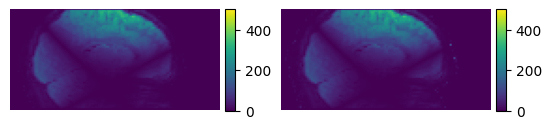

In [36]:
org_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/approx_Lcorrected_sig.nii.gz').get_fdata()
# emp_corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()
emp_corr_dwi1 = nib.load('/home/local/VANDERBILT/kanakap/gradtensor/src/debug_bval_dwi_hat_200.nii').get_fdata()
slice_idx = 60
# slice = org_dwi1[slice_idx, :,:,20]
# slice = np.flip(np.rot90(slice,3))
# slice = np.nan_to_num(slice)
# fig = plt.figure(figsize = (37,25))
# plt.subplot(1,4,1)
# plt.axis('off')
# cmap = plt.get_cmap('viridis')
# im = plt.imshow(np.abs(slice), cmap=cmap)

# slice = corr_dwi1[slice_idx, :,:,20]
# slice = np.flip(np.rot90(slice,3))
# slice = np.nan_to_num(slice)
# plt.subplot(1,4,2)
# plt.axis('off')
# cmap = plt.get_cmap('viridis')
# im = plt.imshow(np.abs(slice), cmap=cmap)


diff = org_dwi1 - corr_dwi1
slice = diff[:, :,:,50]

slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
m = 0
M = 500
plt.subplot(1,2,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

diff = org_dwi1 - emp_corr_dwi1
slice = diff[:, :,:,50]
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,2,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 500
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

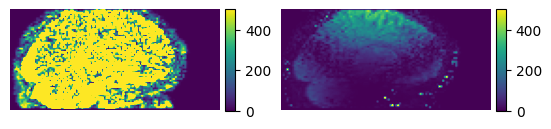

In [41]:
org_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs005/ses-s1Bx3/prequal_dwi_cat/sub-cIVs005_ses-s1Bx3_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/approx_Lcorrected_sig.nii.gz').get_fdata()
emp_corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs005/ses-s1Bx3/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()
slice_idx = 60


diff = org_dwi1 - corr_dwi1
slice = diff[:, :,:,50]
# slice = np.where(mask==1, slice , 0)
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
m = 0
M = 500
plt.subplot(1,2,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

diff = org_dwi1 - emp_corr_dwi1
slice = diff[:, :,:,50]
# slice = np.where(mask==1, slice , 0)
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,2,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 500
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

In [183]:
org_dwi1.shape

(112, 112, 54, 112)

In [46]:
slice.shape

(54, 112)

In [24]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mask.nii.gz').get_fdata()
mask = mask.astype(int)

In [132]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)

In [128]:
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=2).astype(mask.dtype)

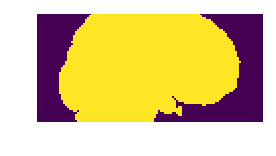

In [129]:

slice = mask[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(1,2,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice),cmap=cmap)
# divider = make_axes_locatable(plt.gca())
# ax = divider.append_axes("right", size="5%", pad=0.05)
# a = plt.colorbar(im, cax=ax)

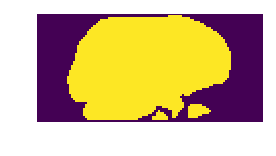

In [131]:
slice = mask[60, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(1,2,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice),cmap=cmap)